In [1]:
import numpy as np
import matplotlib.pyplot as plt
import napari
import pandas as pd
from anndata import AnnData, read_h5ad
import scanpy as sc


In [39]:
#%matplotlib qt
%matplotlib inline

In [3]:
def bin_aps(aps, bins):
    _counts, bins = np.histogram(aps, bins)
    bins = bins[1:]
    binned_aps = np.zeros_like(aps)
    for i in range(len(binned_aps)):
        binned_aps[i] = get_ap_bin(aps[i], bins)
    
    return binned_aps
    

def get_ap_bin(this_ap, bins):
    this_bin = np.where(np.abs(this_ap - bins) == np.nanmin(np.abs(this_ap - bins)))[0][0]

    return this_bin


## Load and preprocess the data

In [51]:
file_path = r'/media/brandon/Data2/Brandon/fly_immune/Flysta3d/L3_b_count_normal_stereoseq.h5ad'
adata = read_h5ad(file_path)

In [52]:
"""create AP bins"""
n_y_bins = 5
all_ys = np.array(adata.obs['new_y'])
y_bins = np.linspace(np.min(all_ys), np.max(all_ys), n_y_bins)
print(f'The anterior-posterior axis goes from {np.min(all_ys)} to {np.max(all_ys)}')

The anterior-posterior axis goes from -178.66514999999998 to 193.73085


In [53]:
"""filter reads to 5% detection"""
detection_percent = np.sum(adata.layers['raw_counts'] > 0, axis=0) / len(adata.layers['raw_counts'])
detection_sel = detection_percent > 0.05
adata = adata[:, detection_sel]

"""get selection of just fat body cells"""
annotation = np.array(adata.obs['annotation'])
fb_sel = (annotation == 'fat body')
adata = adata[fb_sel]

"""replace the log1p-normalized dataset with analytic pearson residuals. store log1p as a new layer"""
adata.layers['log1p'] = adata.X
adata.X = sc.experimental.pp.normalize_pearson_residuals(adata, layer='raw_counts', theta=50, inplace=False)['X']

/tmp/ipykernel_3591166/3656698918.py:12: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  adata.layers['log1p'] = adata.X


In [54]:
"""bin the AP axis"""
ys = np.array(adata.obs['new_y'])
binned_ys = bin_aps(ys, y_bins)
ap_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
adata.obs['anterior_posterior_position'] = [ap_labels[int(b)] for b in binned_ys]
adata.obs['anterior_posterior_position'] = adata.obs['anterior_posterior_position'].astype('category')

In [55]:
adata

AnnData object with n_obs × n_vars = 6628 × 6505
    obs: 'slice_ID', 'raw_x', 'raw_y', 'new_x', 'new_y', 'new_z', 'annotation', 'anterior_posterior_position'
    uns: 'annotation_colors'
    obsm: 'X_umap', 'spatial'
    layers: 'raw_counts', 'log1p'

## Clustering and UMAP

In [56]:
"""run the pre-clustering and clustering routines"""
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, n_iterations=2, resolution=0.04, flavor='igraph')

## Plot UMAPs colored by both clusters and AP position

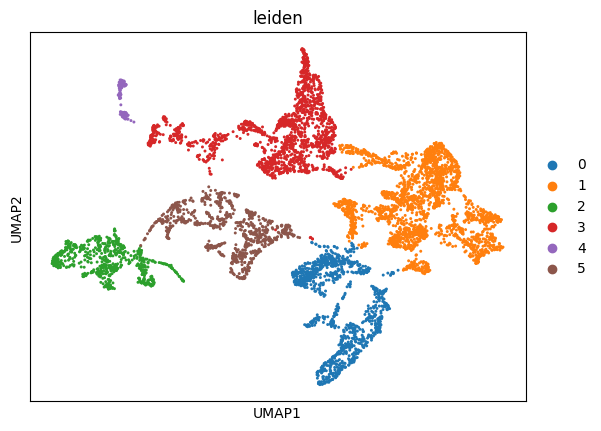

In [57]:
"""colored by cluster"""
sc.pl.umap(adata, color='leiden')

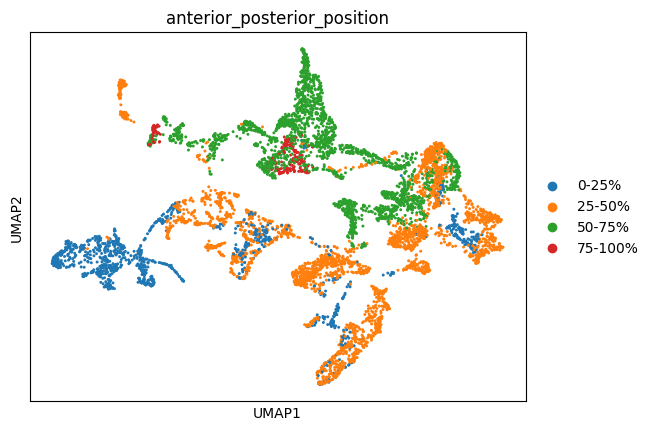

In [62]:
"""colored by AP"""
sc.pl.umap(adata, color='anterior_posterior_position')

## View clusters spatially within the larva

In [81]:
help(viewer.add_points)

Help on method add_points:

add_points(data=None, *, ndim=None, features=None, feature_defaults=None, properties=None, text=None, symbol='o', size=10, edge_width=0.05, edge_width_is_relative=True, edge_color='dimgray', edge_color_cycle=None, edge_colormap='viridis', edge_contrast_limits=None, face_color='white', face_color_cycle=None, face_colormap='viridis', face_contrast_limits=None, out_of_slice_display=False, n_dimensional=None, name=None, metadata=None, scale=None, translate=None, rotate=None, shear=None, affine=None, opacity=1, blending='translucent', visible=True, cache=True, property_choices=None, experimental_clipping_planes=None, shading='none', canvas_size_limits=(2, 10000), antialiasing=1, shown=True) -> napari.layers.points.points.Points method of napari.viewer.Viewer instance
    Add a Points layer to the layer list.

    Parameters
    ----------
    data : array (N, D)
        Coordinates for N points in D dimensions.
    ndim : int
        Number of dimensions for shap

In [82]:
# get colormap to match UMAP clusters. For now, the default mpl color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# extract the points of each cell and swap x and z coordinates so to comply with naparis zyx convention.
points = adata.obsm['spatial']
points[:, [0,2]] = points[:, [2,0]]

# view each cluster's points at a time. convert to a DataFrame first for convenience
points_df = pd.DataFrame({'z': points[:,0], 'y': points[:,1], 'x':points[:,2], 'cluster':adata.obs['leiden'].values})
viewer = napari.Viewer()
for i, p in enumerate(points_df.cluster.unique()):
    these_points = points_df[points_df.cluster == p].get(['z', 'y', 'x']).values
    viewer.add_points(these_points, size=2, face_color=colors[i], name=f'subcluster {i}')

# widen the z coordinate for clarity
for layer in viewer.layers:
   layer.scale = (5, 1, 1)

viewer.dims.ndisplay = 3

In [76]:
viewer

Viewer(camera=Camera(center=(29.75, 2.8964249999999936, -3.783050000000003), zoom=3.2259191074211735, angles=(-77.29686970104825, -48.29293429423288, -80.65099051939806), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(3.528132420555469, -62.851850803801184, -17.322788454203238), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((3.5, 61.0, 5.0), (-178.21475, 185.0076, 1.0), (-72.07325, 65.50715, 1.0)), current_step=(2, 104, 51), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'these_points' at 0x7fc834465be0>, <Points layer 'these_points [1]' at 0x7fc8345128d0>, <Points layer 'these_points [2]' at 0x7fc834512f00>, <Points layer 'these_points [3]' at 0x7fc83413ac00>, <Points layer 'these_points [4]' at 0x7fc82d988aa0>, <Points layer 'these_points [5]' at 0x7fc834374290>], help='use <5> for transform, use <2> for add po

## Identify marker genes that separate subclusters
While we used pearson residuals to identify subclusters, we use regular log1p normalized counts for differential expression analysis

In [65]:
"""identify and filter marker genes"""
sc.tl.rank_genes_groups(adata, groupby='leiden', method="wilcoxon", corr_method='bonferroni', layer='log1p')

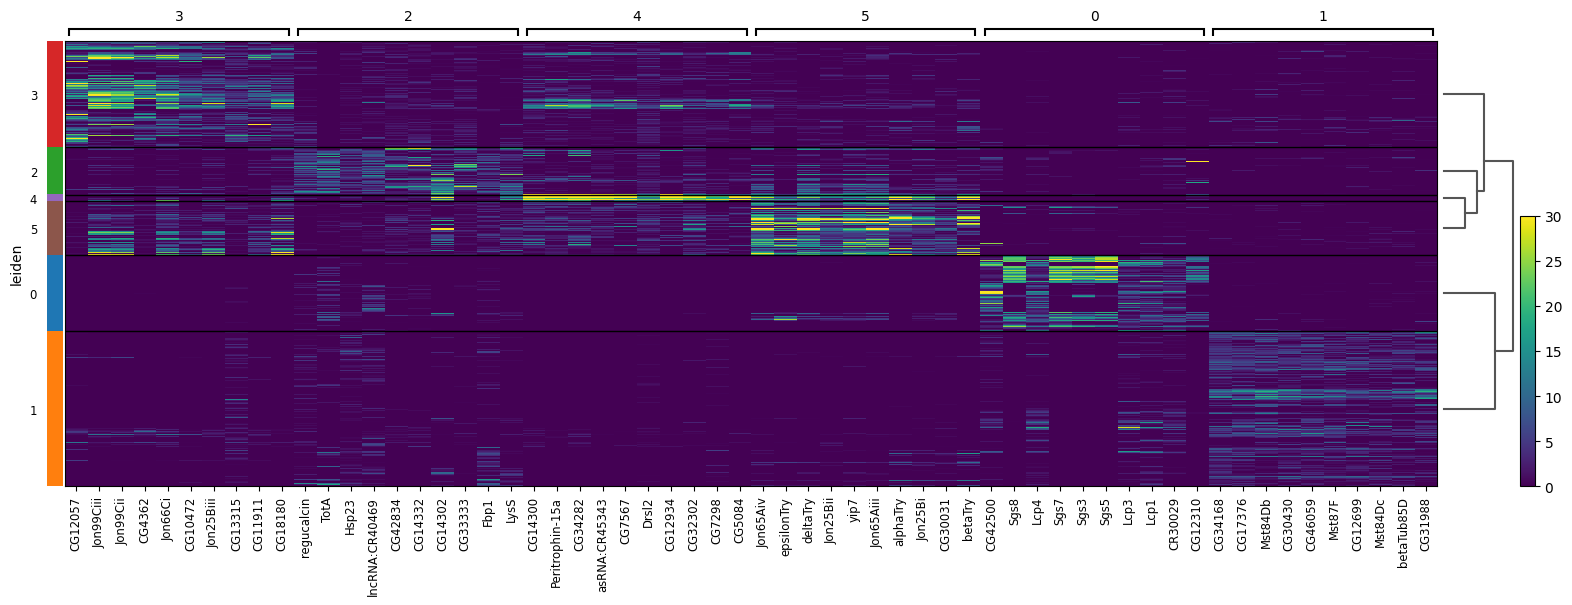

In [68]:
sc.pl.rank_genes_groups_heatmap(
    adata, groupby='leiden', key='rank_genes_groups', vmin=0, vmax=30, show_gene_labels=True, min_logfoldchange=1)

## Plot AP-distributions of identified genes